<a href="https://colab.research.google.com/github/jaeyoonjeong9024/8-weeks/blob/main/CBAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
# 필요 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Flatten, Conv1D, MaxPooling1D, concatenate,
    GlobalAveragePooling1D, Reshape, multiply, # 💡 SE/CBAM 공통
    GlobalMaxPooling1D, add, Lambda # 💡 CBAM에 추가로 필요
)
import tensorflow.keras.backend as K # 💡 Lambda 레이어용
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [43]:
# (원본) 파일 로드
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

# (원본) 파일 그룹 로드
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    loaded = np.dstack(loaded)
    return loaded

# (원본) 데이터셋 그룹 로드 (train 또는 test)
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # 9개 파일명 생성 (acc 3+3, gyro 3)
    filenames = list()
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # 로드
    X = load_group(filenames, filepath)
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

# (원본) 전체 데이터셋 로드
def load_dataset(prefix=''):
    base_path = prefix + '/content/drive/MyDrive/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/'
    trainX, trainy = load_dataset_group('train', base_path)
    testX, testy = load_dataset_group('test', base_path)
    # 레이블 0-5로 조정 및 원-핫 인코딩
    trainy = trainy - 1
    testy = testy - 1
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print("trainX shape:", trainX.shape, " testX shape:", testX.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [44]:
# 데이터 로드
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

# 학습/검증 데이터 분할
X_train, X_val, y_train_one_hot, y_val_one_hot = train_test_split(
    trainX, trainy_one_hot, test_size=0.2, random_state=100
)

# 모델 파라미터 설정
n_timesteps = X_train.shape[1]
n_features = X_train.shape[2]
n_outputs = y_train_one_hot.shape[1]

/tmp/ipython-input-4245881589.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-4245881589.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-4245881589.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-4245881589.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


trainX shape: (7352, 128, 9)  testX shape: (2947, 128, 9)


/tmp/ipython-input-4245881589.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


In [45]:
def cbam_block(input_tensor, reduction_ratio=16, spatial_kernel_size=7):
    """CBAM: Channel Attention + Spatial Attention"""
    channels = input_tensor.shape[-1]

    # --- 1. Channel Attention Module (CAM) ---
    # Shared MLP
    shared_mlp_1 = Dense(channels // reduction_ratio, activation='relu')
    shared_mlp_2 = Dense(channels)

    # AvgPool
    avg_pool = GlobalAveragePooling1D()(input_tensor)
    avg_pool = Reshape((1, channels))(avg_pool)
    avg_pool = shared_mlp_1(avg_pool)
    avg_pool = shared_mlp_2(avg_pool)

    # MaxPool
    max_pool = GlobalMaxPooling1D()(input_tensor)
    max_pool = Reshape((1, channels))(max_pool)
    max_pool = shared_mlp_1(max_pool)
    max_pool = shared_mlp_2(max_pool)

    # Add + Sigmoid
    channel_attention = tf.keras.activations.sigmoid(add([avg_pool, max_pool]))
    # Rescale (Channel Refined)
    channel_refined = multiply([input_tensor, channel_attention])

    # --- 2. Spatial Attention Module (SAM) ---
    # Pool across channels
    avg_pool = Lambda(lambda x: K.mean(x, axis=-1, keepdims=True))(channel_refined)
    max_pool = Lambda(lambda x: K.max(x, axis=-1, keepdims=True))(channel_refined)
    concat = concatenate([avg_pool, max_pool], axis=-1)

    # Conv + Sigmoid
    spatial_attention = Conv1D(1, spatial_kernel_size, padding='same', activation='sigmoid')(concat)

    # Rescale (Final Output)
    return multiply([channel_refined, spatial_attention])

In [46]:
## Level_1
inputs1_1= Input(shape=(n_timesteps,n_features))
conv1_1 = Conv1D(filters=128, kernel_size=3, activation='relu')(inputs1_1)
inputs1_2= Input(shape=(n_timesteps,n_features))
conv1_2 = Conv1D(filters=128, kernel_size=5, activation='relu')(inputs1_2)
inputs1_3= Input(shape=(n_timesteps,n_features))
conv1_3 = Conv1D(filters=128, kernel_size=7, activation='relu')(inputs1_3)
inputs1_4= Input(shape=(n_timesteps,n_features))
conv1_4 = Conv1D(filters=128, kernel_size=9, activation='relu')(inputs1_4)
# merge1
merged_1 = concatenate([conv1_1,conv1_2,conv1_3,conv1_4],axis=1)
cbam_1 = cbam_block(merged_1) # 💡 (추가)
pool_1 = MaxPooling1D(pool_size=5)(cbam_1) # 💡 (수정) 입력을 cbam_1로

## Level_2
conv2_1 = Conv1D(filters=64, kernel_size=3, activation='relu')(pool_1)
conv2_2 = Conv1D(filters=64, kernel_size=5, activation='relu')(pool_1)
conv2_3 = Conv1D(filters=64, kernel_size=7, activation='relu')(pool_1)
conv2_4 = Conv1D(filters=64, kernel_size=9, activation='relu')(pool_1)
# merge2
merged_2 = concatenate([conv2_1,conv2_2,conv2_3,conv2_4],axis=1)
cbam_2 = cbam_block(merged_2) # 💡 (추가)
pool_2 = MaxPooling1D(pool_size=5)(cbam_2) # 💡 (수정) 입력을 cbam_2로

## Level_3
conv3_1 = Conv1D(filters=32, kernel_size=3, activation='relu')(pool_2)
conv3_2 = Conv1D(filters=32, kernel_size=5, activation='relu')(pool_2)
conv3_3 = Conv1D(filters=32, kernel_size=7, activation='relu')(pool_2)
conv3_4 = Conv1D(filters=32, kernel_size=9, activation='relu')(pool_2)
# merge
merged_3 = concatenate([conv3_1,conv3_2,conv3_3,conv3_4],axis=1)
cbam_3 = cbam_block(merged_3) # 💡 (추가)
pool_3 = MaxPooling1D(pool_size=5)(cbam_3) # 💡 (수정) 입력을 cbam_3으로

## (원본과 동일)
flat_cnn=Flatten()(pool_3)
dense = Dense(512, activation='relu')(flat_cnn)
outputs = Dense(n_outputs, activation='softmax')(dense)

## (원본과 동일) 4-입력 구조
cbam_model = Model([inputs1_1, inputs1_2, inputs1_3,inputs1_4], outputs)

In [47]:
cbam_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cbam_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17      │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_18      │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_19      │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_20      │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_72 (Conv1D)  │ (None, 126, 128)  │      3,584 │ input_layer_17[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_73 (Conv1D)  │ (None, 124, 128)  │      5,888 │ input_layer_18[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_74 (Conv1D)  │ (None, 122, 128)  │      8,192 │ input_layer_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_75 (Conv1D)  │ (None, 120, 128)  │     10,496 │ input_layer_20[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_12      │ (None, 492, 128)  │          0 │ conv1d_72[0][0],  │
│ (Concatenate)       │                   │            │ conv1d_73[0][0],  │
│                     │                   │            │ conv1d_74[0][0],  │
│                     │                   │            │ conv1d_75[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ concatenate_12[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ concatenate_12[0… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 1, 128)    │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 1, 128)    │          0 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 1, 8)      │      1,032 │ reshape_3[0][0],  │
│                     │                   │            │ reshape_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 1, 128)    │      1,152 │ dense_16[0][0],   │
│                     │                   │            │ dense_16[1][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 1, 128)    │          0 │ dense_17[0][0],   │
│                     │                   │            │ dense_17[1][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sigmoid (Sigmoid)   │ (None, 1, 128)    │          0 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_3          │ (None, 492, 128)  │          0 │ concatenate_12[0… │
│ (Multiply)          │                   │            │ sigmoid[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,181,985 (4.51 MB)

 Trainable params: 1,181,985 (4.51 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
print("CBAM-CNN (4-Input) 모델 학습 시작...")

model_history = cbam_model.fit(
    x=[X_train, X_train, X_train, X_train], # 💡 (원본 방식 유지)
    y=y_train_one_hot,
    epochs=30,
    batch_size=32,
    validation_data=([X_val, X_val, X_val, X_val], y_val_one_hot)
)

print("학습 완료.")

CBAM-CNN (4-Input) 모델 학습 시작...
Epoch 1/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 74s 361ms/step - accuracy: 0.5400 - loss: 1.0471 - val_accuracy: 0.9239 - val_loss: 0.1732
Epoch 2/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 65s 267ms/step - accuracy: 0.9451 - loss: 0.1351 - val_accuracy: 0.9524 - val_loss: 0.1124
Epoch 3/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 51s 279ms/step - accuracy: 0.9538 - loss: 0.1023 - val_accuracy: 0.9531 - val_loss: 0.1060
Epoch 4/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 50s 274ms/step - accuracy: 0.9468 - loss: 0.1227 - val_accuracy: 0.9531 - val_loss: 0.1101
Epoch 5/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 81s 270ms/step - accuracy: 0.9531 - loss: 0.1022 - val_accuracy: 0.9497 - val_loss: 0.1183
Epoch 6/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 82s 270ms/step - accuracy: 0.9574 - loss: 0.1030 - val_accuracy: 0.9531 - val_loss: 0.1172
Epoch 7/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 54s 293ms/step - accuracy: 0.9600 - loss: 0.0999 - val_accuracy: 0.9558 - val_loss: 0.1089
Epoch 8/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 49s 269ms/st

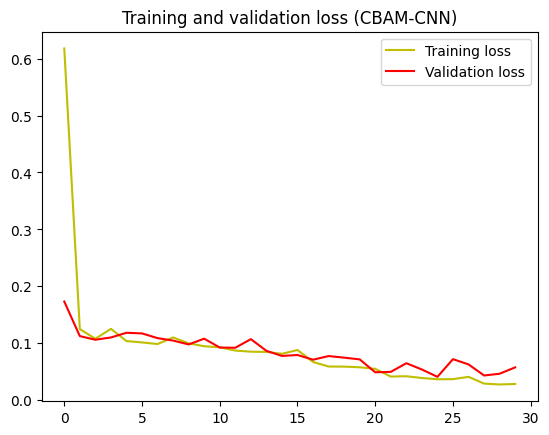

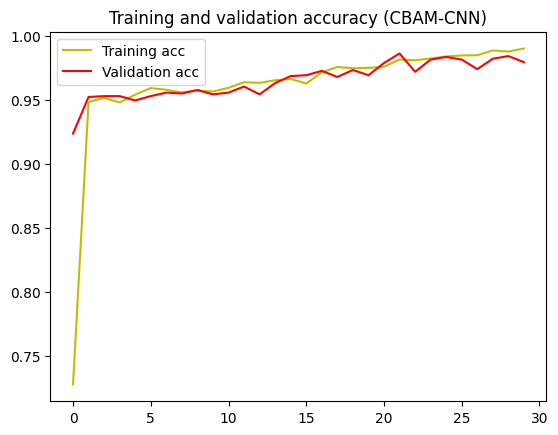

In [49]:
# 손실(Loss) 그래프
plt.plot(model_history.history['loss'], 'y', label='Training loss')
plt.plot(model_history.history['val_loss'], 'r', label='Validation loss')
plt.title('Training and validation loss (CBAM-CNN)')
plt.legend()
plt.show()

# 정확도(Accuracy) 그래프
plt.plot(model_history.history['accuracy'], 'y', label='Training acc')
plt.plot(model_history.history['val_accuracy'], 'r', label='Validation acc')
plt.title('Training and validation accuracy (CBAM-CNN)')
plt.legend()
plt.show()

93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step
--- Confusion Matrix ---
[[470   5  20   1   0   0]
 [  0 459  12   0   0   0]
 [  0  16 404   0   0   0]
 [  0   3   0 411  71   6]
 [  0   0   0  38 494   0]
 [  0   4   0   0   0 533]]

--- Accuracy Score ---
0.9402782490668476

--- Classification Report ---
              precision    recall  f1-score   support

           0       1.00      0.95      0.97       496
           1       0.94      0.97      0.96       471
           2       0.93      0.96      0.94       420
           3       0.91      0.84      0.87       491
           4       0.87      0.93      0.90       532
           5       0.99      0.99      0.99       537

    accuracy                           0.94      2947
   macro avg       0.94      0.94      0.94      2947
weighted avg       0.94      0.94      0.94      2947



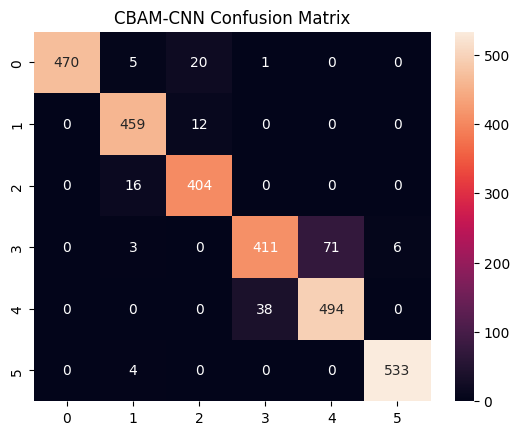

In [50]:
# 예측
pred_cbam = cbam_model.predict([testX, testX, testX, testX]) # 💡 (원본 방식 유지)
pred_classes = np.argmax(pred_cbam, axis=-1)

# 평가
cm = confusion_matrix(testy, pred_classes)
print("--- Confusion Matrix ---")
print(cm)
print("\n--- Accuracy Score ---")
print(accuracy_score(testy, pred_classes))
print("\n--- Classification Report ---")
print(classification_report(testy, pred_classes))

# Heatmap
sns.heatmap(cm, annot=True, fmt='d')
plt.title('CBAM-CNN Confusion Matrix')
plt.show()